# Evaluating Address Parsers
There are several well known python address parsing libraries. To decide which to use in a backend application, I'll gather addresses. Introduce errors into them and then measure accuracy (% parsed correctly) and speed (time in ms)

Libraries considered:
- [usaddress](https://github.com/datamade/usaddress)
- [address](https://pypi.org/project/address/)
- [postal](https://github.com/openvenues/pypostal)

The first two seem pretty standard, the last is a super-duper machine learning implementation, but I'm concerned about speed and curious to see if it's really better than a deterministic approach.

Data is from [open addresses](https://openaddresses.io/). To replicate from original data unpack all regional data from open addresses to one directory with structure us > state_name > *.csv

Otherwise load processed data from `random-addresses-usa.csv` created below

## Gather Data

In [78]:
import pandas as pd

In [2]:
import glob
keep_row_n=50
df_list = []
relevant_fields = ['NUMBER', 'STREET', 'UNIT', 'CITY', 'POSTCODE']
for file_path in glob.iglob('**/*.csv'):
    num_lines_in_file = sum(1 for _ in open(file_path))
    skip_idx = [x for x in range(1, num_lines_in_file) if x % keep_row_n != 0]
    try:
        # only import every 50th row
        selected_rows = pd.read_csv(file_path, usecols=relevant_fields, skiprows=skip_idx, engine='c')
    except:
        print file_path + " threw an error"
        continue
#     add state names to df before appending
    state_name = file_path[0:2]
    selected_rows['STATE'] = state_name
    df_list.append(selected_rows)

/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


or/washington-state-summary.csv threw an error


In [3]:
addresses_df = pd.concat(df_list)

## Clean (and then introduce errors)
- [x] Make Variation in street designation (i.e. "st. vs str. vs. street")
- [x] Make Variation in state (California, CA, ca)
- [x] Make variation in street number (including abscence)
- [x] Make Misspellings
- [x] Make some entries only have city name

In [4]:
addresses_df = addresses_df[['NUMBER', 'STREET', 'UNIT', 'CITY', 'STATE', 'POSTCODE']]
addresses_df = addresses_df[addresses_df.notnull().all(axis=1)]

In [225]:
clean_addresses = addresses_df.copy()
clean_addresses['STREET'] = clean_addresses['STREET'].str.title()
clean_addresses['CITY'] = clean_addresses['CITY'].str.title()
clean_addresses['STATE'] = clean_addresses['STATE'].str.upper()
clean_addresses_small = clean_addresses.sample(n=5000, random_state=1)
clean_addresses_small = clean_addresses_small.reset_index(drop=True)
print(clean_addresses_small.shape)
clean_addresses_small.head(10)

(5000, 6)


,NUMBER,STREET,UNIT,CITY,STATE,POSTCODE
0,1316,S 400 E St,UNIT 1C,St George,UT,84790
1,1419,Grand St,103,Alameda,CA,94501
2,66,Easton Street,1,Lawrence,MA,1843
3,4600,Fegenbush Ln,10,Louisville,KY,40228
4,2600,S Ocean Dr,S 315,Hollywood,FL,33019
5,6899,Dollymount Dr,UNIT B,Ocala,FL,34472
6,7122,Cross Rd,B,Winneconne,WI,54986
7,207,High St,APT 4,Portland,ME,4101
8,2011,Chapel Plaza Ct,STE 9,Columbia,MO,65203
9,22,North Mcnab Avenue,Apartment 1,Gloversville,NY,12078


In [6]:
dirty_addresses_small = clean_addresses_small.copy()

In [7]:
state_names = {
    "AL": "Alabama",
    "AK": "Alaska",
    "AS": "American Samoa",
    "AZ": "Arizona",
    "AR": "Arkansas",
    "CA": "California",
    "CO": "Colorado",
    "CT": "Connecticut",
    "DE": "Delaware",
    "DC": "District Of Columbia",
    "FM": "Federated States Of Micronesia",
    "FL": "Florida",
    "GA": "Georgia",
    "GU": "Guam",
    "HI": "Hawaii",
    "ID": "Idaho",
    "IL": "Illinois",
    "IN": "Indiana",
    "IA": "Iowa",
    "KS": "Kansas",
    "KY": "Kentucky",
    "LA": "Louisiana",
    "ME": "Maine",
    "MH": "Marshall Islands",
    "MD": "Maryland",
    "MA": "Massachusetts",
    "MI": "Michigan",
    "MN": "Minnesota",
    "MS": "Mississippi",
    "MO": "Missouri",
    "MT": "Montana",
    "NE": "Nebraska",
    "NV": "Nevada",
    "NH": "New Hampshire",
    "NJ": "New Jersey",
    "NM": "New Mexico",
    "NY": "New York",
    "NC": "North Carolina",
    "ND": "North Dakota",
    "MP": "Northern Mariana Islands",
    "OH": "Ohio",
    "OK": "Oklahoma",
    "OR": "Oregon",
    "PW": "Palau",
    "PA": "Pennsylvania",
    "PR": "Puerto Rico",
    "RI": "Rhode Island",
    "SC": "South Carolina",
    "SD": "South Dakota",
    "TN": "Tennessee",
    "TX": "Texas",
    "UT": "Utah",
    "VT": "Vermont",
    "VI": "Virgin Islands",
    "VA": "Virginia",
    "WA": "Washington",
    "WV": "West Virginia",
    "WI": "Wisconsin",
    "WY": "Wyoming"
}

In [10]:
import random
import numpy
import string
import re
def change_street_designation(street):
    street = str(street)
    street = random.choice([street.lower(), street.lower().title()])
    last_word = street.split(' ')[-1].upper()
    designations = {
        'RD': ['rd', 'road', 'ROad',''],
        'ST': ['st', 'street', 'Street', 'StrEET'],
        'AVE': ['ave','avenue', 'Avenue', 'Av', 'AvENUE'],
        'DR': ['dr', 'drive', 'Drive', 'DRIVE'],
        'WAY': ['way', 'w'],
        'LN': ['ln', 'lane', 'Lane', 'LANE'],
        'PL':['pl', 'place', 'Place', 'plACE'],
        'CIR':['cir', 'circle', 'Circle', 'cr', 'CIRCLE'],
        'CT': ['ct', 'Court', 'crt', 'court', 'COURT'],
        'BLVD': ['blvd', 'boulevard', 'bouleVARD'],
        'SQ': ['sq', 'sqr', 'square', 'SQUARE'],
    }
    
    if last_word in designations:
        random_street_designation = random.choice(designations[last_word])
        return re.sub(last_word, random_street_designation, street, flags=re.IGNORECASE)
    else:
        return street
    
def make_state_name_random(item):
    state_name = str(item)
    if state_name in state_names:
        long_state_name = state_names[state_name]
        return random.choice([state_name, long_state_name, long_state_name.lower()])

    
def make_null(item):
    return numpy.nan

def make_misspelling(item):
    item = str(item)
    random_index = random.randint(0, len(item) - 1)
    misspelled_item = item[:random_index] + random.choice(string.ascii_letters + string.digits) + item[random_index + 1:]
    return misspelled_item


def make_randomly_dirty(item, function_to_apply, one_in_every_n = 50):
    """
    randomly apply function
    range of random int is the probability item will be modified
    application of function_to_apply is recursive to make multiple changes at random
    """
    if random.randint(0, one_in_every_n) == 1:
        return make_randomly_dirty(function_to_apply(item), function_to_apply)
    else:
        return item


In [11]:
dirty_addresses_small['UNIT'] = dirty_addresses_small['UNIT'].apply(lambda item: make_randomly_dirty(item, make_misspelling))
dirty_addresses_small['UNIT'] = dirty_addresses_small['UNIT'].apply(lambda item: make_randomly_dirty(item, make_null))
dirty_addresses_small['NUMBER'] = dirty_addresses_small['NUMBER'].apply(lambda item: make_randomly_dirty(item, make_misspelling))
dirty_addresses_small['NUMBER'] = dirty_addresses_small['NUMBER'].apply(lambda item: make_randomly_dirty(item, make_null))
dirty_addresses_small['STREET'] = dirty_addresses_small['STREET'].apply(lambda item: make_randomly_dirty(item, make_misspelling))
dirty_addresses_small['STREET'] = dirty_addresses_small['STREET'].apply(lambda item: make_randomly_dirty(item, make_null))
dirty_addresses_small['STREET'] = dirty_addresses_small['STREET'].apply(lambda item: make_randomly_dirty(item, change_street_designation))
dirty_addresses_small['CITY'] = dirty_addresses_small['CITY'].apply(lambda item: make_randomly_dirty(item, make_misspelling))
dirty_addresses_small['CITY'] = dirty_addresses_small['CITY'].apply(lambda item: make_randomly_dirty(item, make_null))
dirty_addresses_small['STATE'] = dirty_addresses_small['STATE'].apply(lambda item: make_randomly_dirty(item, make_state_name_random))
dirty_addresses_small['STATE'] = dirty_addresses_small['STATE'].apply(lambda item: make_randomly_dirty(item, make_misspelling))
dirty_addresses_small['STATE'] = dirty_addresses_small['STATE'].apply(lambda item: make_randomly_dirty(item, make_null))

In [12]:
dirty_addresses_small.head(20)

,NUMBER,STREET,UNIT,CITY,STATE,POSTCODE
0,131K,S 400 E St,UNIT 1C,St George,UT,84790
1,1419,Grand St,103,Alameda,CA,94501
2,66,Easton Street,1,Lawrpnce,MA,1843
3,4600,Fegenbush Ln,10,Louisville,KY,40228
4,2600,S Ocean Dr,S 315,Hollywood,FL,33019
5,6899,Dollyiount Dr,UNIT B,Ocala,FL,34472
6,712b,Cross Rd,m,Winneconne,WI,54986
7,207,High St,APT 4,Portland,ME,4101
8,2011,Chapel Plaza Ct,STE 9,Columbia,MO,65203
9,22,North Mcnab Avenue,Apartment 1,Gloversville,NY,12078


In [13]:
def make_address_string(row):
    unicode_string = row.to_string(header=False, index=False, na_rep=' ')
    ascii_string = str(unicode_string)
    no_line_breaks = ascii_string.replace('\n', '')
    stripped = ' '.join(no_line_breaks.split())
    return stripped

def make_obj_list(data_frame):
    addresses_map = []
    for index, row in data_frame.iterrows():
        address_string = make_address_string(row)
        address_object = row.to_dict()
        full_address = {
            'index': index,
            'string': address_string,
            'object': address_object
        }
        addresses_map.append(full_address)
    return addresses_map

In [14]:
clean_address_list = make_obj_list(clean_addresses_small)
dirty_address_list = make_obj_list(dirty_addresses_small)

In [15]:
print(len(clean_address_list))
clean_address_list[0]

5000


{'index': 0,
 'object': {'CITY': 'St George',
  'NUMBER': 1316,
  'POSTCODE': 84790,
  'STATE': 'UT',
  'STREET': 'S 400 E St',
  'UNIT': 'UNIT 1C'},
 'string': '1316 S 400 E St UNIT 1C St George UT 84790'}

In [16]:
print(len(dirty_address_list))
dirty_address_list[0]

5000


{'index': 0,
 'object': {'CITY': 'St George',
  'NUMBER': '131K',
  'POSTCODE': 84790,
  'STATE': 'UT',
  'STREET': 'S 400 E St',
  'UNIT': 'UNIT 1C'},
 'string': '131K S 400 E St UNIT 1C St George UT 84790'}

In [2]:
def normalize_address_object(parser_name, address):
    if parser_name == 'usaddress':
        try:
            address = json.loads(json.dumps(address))[0]
        except:
            address = {}
            print("Failed to Serialize", address)
        
        return {
            'NUMBER': address.get('AddressNumber'),
            'POSTCODE': address.get('ZipCode'),
            'STATE': address.get('StateName'),
            'STREET': address.get('StreetName', '') + ' ' + address.get('StreetNamePostType', '') if address.get('StreetName') and address.get('StreetName') else None,
            'CITY': address.get('PlaceName'),
            'UNIT': address.get('OccupancyIdentifier')
        }
    elif parser_name == "postal":
        def get_address_from_list(selector, address):
            for i in address:
                if i[1] == selector:
                    return i[0]
        return {
            'NUMBER':get_address_from_list('house_number', address),
            'POSTCODE':get_address_from_list('postcode', address),
            'STATE':get_address_from_list('state', address),
            'STREET':get_address_from_list('road', address),
            'CITY':get_address_from_list('city', address),
            'UNIT': get_address_from_list('unit', address)
        }
    elif parser_name == "address":
        return {
            'NUMBER': address.house_number,
            'POSTCODE': address.zip,
            'STATE': address.state,
            'CITY': address.city,
            'STREET': address.street,
            'UNIT': address.apartment or address.building
        }

Check that libraries parse as expected

In [18]:
import usaddress
import json
usaddress_object = usaddress.tag('123 Main st. Suit 100, IL 93901')
# usaddress_object = json.loads(json.dumps(parsed_address))
print(usaddress_object)
normalize_address_object('usaddress', usaddress_object)

(OrderedDict([('AddressNumber', u'123'), ('StreetName', u'Main'), ('StreetNamePostType', u'st.'), ('OccupancyType', u'Suit'), ('OccupancyIdentifier', u'100'), ('StateName', u'IL'), ('ZipCode', u'93901')]), 'Street Address')


{'CITY': None,
 'NUMBER': u'123',
 'POSTCODE': u'93901',
 'STATE': u'IL',
 'STREET': u'Main st.',
 'UNIT': u'100'}

In [5]:
from postal.parser import parse_address
postal_object = parse_address('123 Main st. Suite 100, Chicago, IL 93910')
print(postal_object)
normalize_address_object('postal', postal_object)

[(u'123', u'house_number'), (u'main st.', u'road'), (u'suite 100', u'unit'), (u'chicago', u'city'), (u'il', u'state'), (u'93910', u'postcode')]


{'CITY': u'chicago',
 'NUMBER': u'123',
 'POSTCODE': u'93910',
 'STATE': u'il',
 'STREET': u'main st.',
 'UNIT': u'suite 100'}

In [20]:
from address import AddressParser, Address
ap = AddressParser()
address_object = ap.parse_address('123 main st. 3 Suite 100, IL')
print(address_object)
normalize_address_object('address', address_object )

Address - House number: 3 Prefix: None Street: Suite Suffix: None Apartment: 100 Building: 123 main st City,State,Zip: None IL None


{'CITY': None,
 'NUMBER': '3',
 'POSTCODE': None,
 'STATE': 'IL',
 'STREET': 'Suite',
 'UNIT': '100'}

In [118]:
from timeit import timeit

def difference_case_insensitive(dictOne, dictTwo):
    """
    returns difference between objects or False if there is none
    """
    
    def clean(value):
        if type(value) == float and not numpy.isnan(value):
            return str(int(value))
        elif type(value) == str or type(value) == unicode:
            return value.lower()
        elif type(value) == int:
            return str(value)
        elif value == None or numpy.isnan(value):
            return None
    
    for key in dictOne.keys():
        
        if key in dictTwo:
        
            keyOne = clean(dictOne[key])
            keyTwo = clean(dictTwo[key])

            if keyOne != keyTwo:
                return (key, dictOne[key], dictTwo[key])
        
    return False
    

def test_with(addresses, parser_name, parser_func):
    """
    Takes in:
    - a list of address objects structured like
        {'index': 26,
          'object': {'CITY': ' CO',
           'NUMBER': 16103,
           'POSTCODE': '80017-2175',
           'STATE': 'co',
           'STREET': 'E ALASKA PL',
           'UNIT': '5'},
          'string': '16103 E ALASKA PL 5 CO 80017-2175 co'
        },
    - the name of the parsing library
    - the parsing function from that library (e.g. package.parse_address not package )
    """
    
    execution_time = []
    success_count = 0
    list_of_failures = []
    for address in addresses:
        
        try:
            # have to use lambda function to mock a function that takes no parameters for timeit
            avg_time_ms  = timeit(lambda: parser_func(address["string"]), number=10) / 10
            execution_time.append(avg_time_ms)
        except:
            print("Errored on: ", address["string"])
            continue
            

        try:
            parsed_result = parser_func(address["string"])
        except:
            print("Errored on: ", address["string"])
            continue
            
        difference = difference_case_insensitive(normalize_address_object(parser_name, parsed_result), address["object"])
        if difference:
            list_of_failures.append({
                'address': address["string"],
                'error': difference,
                'parsed_result': parsed_result
            })
        else:
            success_count += 1
    return {
        'execution_time': execution_time,
        'success_count': success_count,
        'failures': list_of_failures
    }

In [178]:
test = {
    'clean':{
        'address': test_with(clean_address_list, 'address', ap.parse_address),
        'postal': test_with(clean_address_list, 'postal', parse_address),
        'usaddress': test_with(clean_address_list, 'usaddress', ap.parse_address)
    },
    'dirty':{
        'address': test_with(dirty_address_list, 'address', ap.parse_address),
        'postal': test_with(dirty_address_list, 'postal', parse_address),
        'usaddress': test_with(dirty_address_list, 'usaddress', ap.parse_address)
    }
}

Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched tok

Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched tok

Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched tok

Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched tok

Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>


Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>


Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched t

Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
U

Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /


Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:

Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:

Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched tok

Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched 

Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched 

Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched 

Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched 

Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched 

Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched 

Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched tok

Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched tok

Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /


Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /


Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched tok

Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched tok

Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched tok

Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:

Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:

Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:

Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /


Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /


Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>


Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /


Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /


Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched tok

('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serializ

Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched tok

('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serializ

Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched tok

Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched tok

Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>


Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>


('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serializ

Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched t

('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serializ

('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:

Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /


('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serializ

Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:

Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})


Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched tok

Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Fail

('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serializ

Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched 

('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serializ

('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serializ

('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serializ

('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serializ

Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched 

Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched 

Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched 

('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serializ

Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched tok

('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serializ

Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /


Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Seri

Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched tok

Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched tok

('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serializ

('Failed to Serialize', {})
('Failed to Serialize', {})
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6

Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched tok

Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched tok

Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:

Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:

('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serializ

Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /


Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /


Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>


Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>


Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /


Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /


('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serializ

('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatc

Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched tok

('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serializ

Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched tok

Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched tok

Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched tok

Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>


Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>


Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched t

Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched t

Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /


Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:

Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:

Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:

Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched tok

Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched 

Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched 

Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched 

Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched 

Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched 

Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched 

Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched tok

Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched tok

Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /


Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /


Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched tok

Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched tok

Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched tok

Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:

Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:

Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:

Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /


Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /


Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>


Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>


Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /


Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched tok

Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched tok

('Failed to Serialize', {})
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatc

Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched tok

('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serializ

Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched tok

('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched

Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>


Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>


('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serializ

Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched t

Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
Unmatched token:  -112
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to 

('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serializ

Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /


('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serializ

Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:

Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:  -2303
Unmatched token:

Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched token:  -1
Unmatched tok

('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serializ

('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serializ

Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched token:  -21
Unmatched 

('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serializ

('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serializ

('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serializ

('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serializ

Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched 

Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched token:  -13
Unmatched 

Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched 

Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched token:  -87
Unmatched 

Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched tok

('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serializ

Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /


Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /


('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched tok

Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched token:  -2
Unmatched tok

('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serializ

('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serializ

Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched token:  -6
Unmatched tok

('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unma

Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:

Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:  -2864
Unmatched token:

('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serializ

('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
Unmatched token:  /
Unmatched token:  /
Unmatche

Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /


('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serializ

Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>


Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>
Unmatched token:  <Null>


Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /
Unmatched token:  /


('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serializ

('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serializ

Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched token:  -4
Unmatched tok

('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serialize', {})
('Failed to Serializ

## Analysis
- graph the number of successes (for clean and dirty)
- graph performance by average and hist
- look at types of errors (mostly postal appending to unit)
    - v.s. none

In [179]:
import matplotlib.pyplot as plt
%matplotlib inline

libraries = ['postal', 'address', 'usaddress']
clean_avg_execution_time = [ numpy.mean(test['clean'][lib]['execution_time']) for lib in libraries]
dirty_avg_execution_time = [ numpy.mean(test['dirty'][lib]['execution_time']) for lib in libraries]

clean_successes = [ test['clean'][lib]['success_count'] for lib in libraries]
dirty_successes = [ test['dirty'][lib]['success_count'] for lib in libraries]

Look at accuracy

['postal', 'address', 'usaddress']
('clean', [1449, 0, 0])
('dirty', [1444, 0, 0])


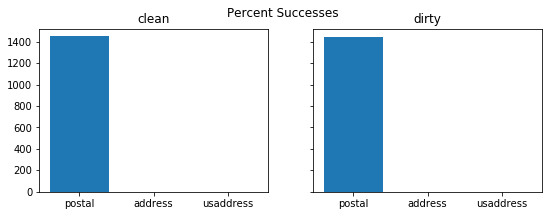

In [192]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
axs[0].bar(libraries, clean_successes)
axs[0].set_title('clean')
axs[1].bar(libraries, dirty_successes)
axs[1].set_title('dirty')
fig.suptitle('Percent Successes')
print(libraries)
print("clean", clean_successes)
print("dirty", dirty_successes)

Wow. They all suck. Looks like postal sucks a little bit less. 

Let's check how many didn't find anything at all (versus finding the wrong thing)

In [219]:
none_count_postal = len(filter(lambda x: x["error"][1] == None, test['clean']['postal']['failures']))
none_count_address = len(filter(lambda x: x["error"][1] == None, test['clean']['address']['failures']))
none_count_usaddress = len(filter(lambda x: x["error"][1] == None, test['clean']['usaddress']['failures']))

print("Not Founds")
print(libraries)
print(none_count_postal, none_count_address, none_count_usaddress)

Not Founds
['postal', 'address', 'usaddress']
(310, 4995, 5000)


So address and usaddress errored on literally all of them, but (not shown) it looks like a lot of postal errors was including the unit number in the street address by accident, which for our purposes is relatively minor. Let's correct for that.

In [184]:
def is_in(str_one, str_two):
    try:
        one_in_two = str_one.lower() in str_two.lower()
        two_in_one = str_two.lower() in str_one.lower()
        return 1 if one_in_two or two_in_one else 0
    except Exception as e:
        print e
        return 0
    

In [185]:
def calc_original_in_parsed(failures):
    adjustment = 0
    for failure in failures:
        error = failure['error']
        parsed = error[1]
        original = error[2]
        adjustment += is_in(original, parsed)
    return adjustment

In [186]:
# would be nice to plot how many None vs how many others
adjusted_clean_successes = [ test['clean'][lib]['success_count'] + calc_original_in_parsed(test['clean'][lib]['failures'])  for lib in libraries]
adjusted_dirty_successes = [ test['dirty'][lib]['success_count'] + calc_original_in_parsed(test['dirty'][lib]['failures']) for lib in libraries]

'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'float' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' obj

'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' 

'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' 

'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' 

'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' 

'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' 

'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'float' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'float' object has no attribute 'lower'
'float' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'float' object has no attribute 'lower'
'float' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no a

'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' 

'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' 

'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' 

'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' 

'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' object has no attribute 'lower'
'NoneType' 

['postal', 'address', 'usaddress']
('clean', [4373, 5, 0])
('dirty', [4052, 6, 0])


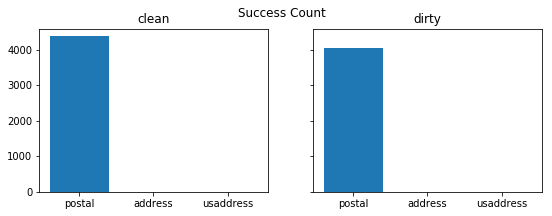

In [191]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
axs[0].bar(libraries, adjusted_clean_successes)
axs[0].set_title('clean')
axs[1].bar(libraries, adjusted_dirty_successes)
axs[1].set_title('dirty')
fig.suptitle('Success Count')
print(libraries)
print("clean", adjusted_clean_successes)
print("dirty", adjusted_dirty_successes)

Much better! (nearly 90% accuracy)

Inspect what kind of errors it's making

In [224]:
for o in filter(lambda x: x["error"][1] == None, test['clean']['postal']['failures'])[:20]:
    print(o['error'])

('UNIT', None, '2667 110th St')
('UNIT', None, '508')
('UNIT', None, '3R')
('CITY', None, ' ')
('UNIT', None, '# 1')
('CITY', None, ' ')
('UNIT', None, '4755 460th St')
('UNIT', None, '27')
('UNIT', None, '105')
('UNIT', None, '102')
('UNIT', None, 'APT')
('UNIT', None, '4')
('UNIT', None, '6')
('UNIT', None, '10731 180th St')
('CITY', None, ' ')
('UNIT', None, '2')
('UNIT', None, '123')
('UNIT', None, '306')
('UNIT', None, '200 Hill Rose Ln')
('UNIT', None, '# 6204')


Looks like most of the errors after correcting for unit number no being stripped from street name aren't that important - i.e. either blank strings, or not detecting unit (which presumably have been captured accidentally in the street address anyway)

Text(0.5,0.98,'Execution Time in Ms')

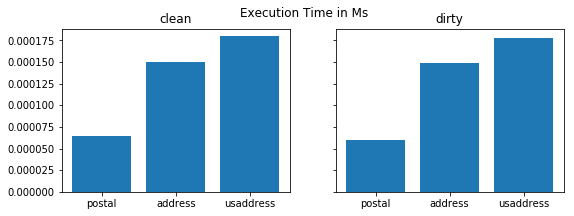

In [221]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
axs[0].bar(libraries, clean_avg_execution_time)
axs[0].set_title('clean')
axs[1].bar(libraries, dirty_avg_execution_time)
axs[1].set_title('dirty')
fig.suptitle('Execution Time in Ms')

TLDR: They're all really fast, but interestingly the most sophisticated in the fastest (probably because it's written in C)

# Conclusion
Address and usaddress are essentially useless. Postal is really accurate once you correct for including unit number in street address. Postals ~87% accuracy will probably go up when we account for empty strings in the test set and not counting lack of unit number in entries where it appended it to the street addresses as an error. Postal is also the fastest, but the difference is trivial.